# Task:  Build a Transfer Learning model to detect face masks on humans.

Classes to be detected:

• "with_mask"

• "without_mask"

• "mask_worn_incorrect"


In [1]:
# !pip install tensorflow
# !pip install tensorflow-datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds


2024-06-04 12:32:44.986424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Task A

## 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3

Creates a tensorflow dataset from an image folder with a directory path to the images
https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder

In [24]:
# Path to datset
PATH = './face_mask_detection_dataset'

batch_size = 32
img_height = 128
img_width = 128

builder = tfds.ImageFolder(PATH, shape=(img_height,img_width,3))
print(builder.info)  # num examples, labels... are automatically calculated


tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/Users/oysterable/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(128, 128, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=900, num_shards=1>,
        'train': <SplitInfo num_examples=8082, num_shards=1>,
    },
    citation="""""",
)


## 2. Load training dataset using Tensorflow dataset builder

2024-06-04 13:18:49.835750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


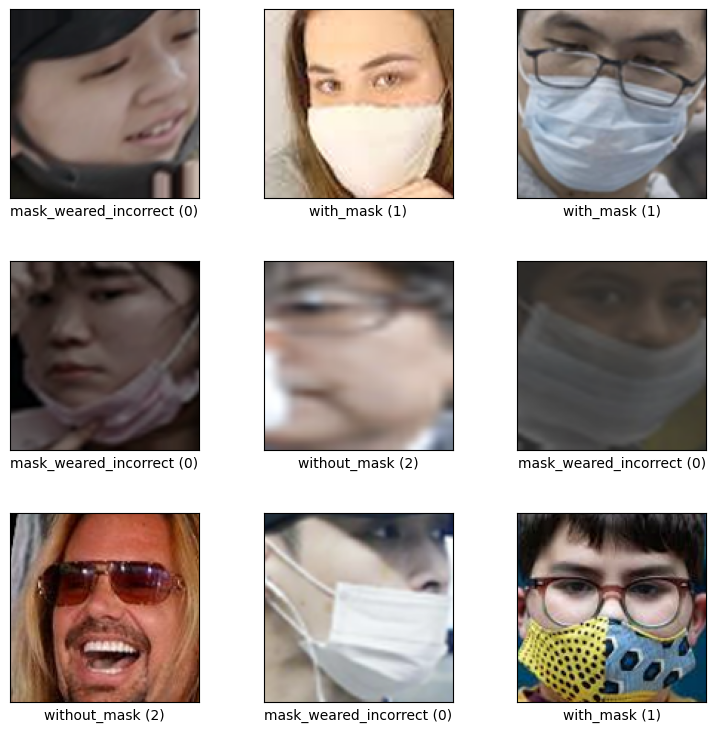

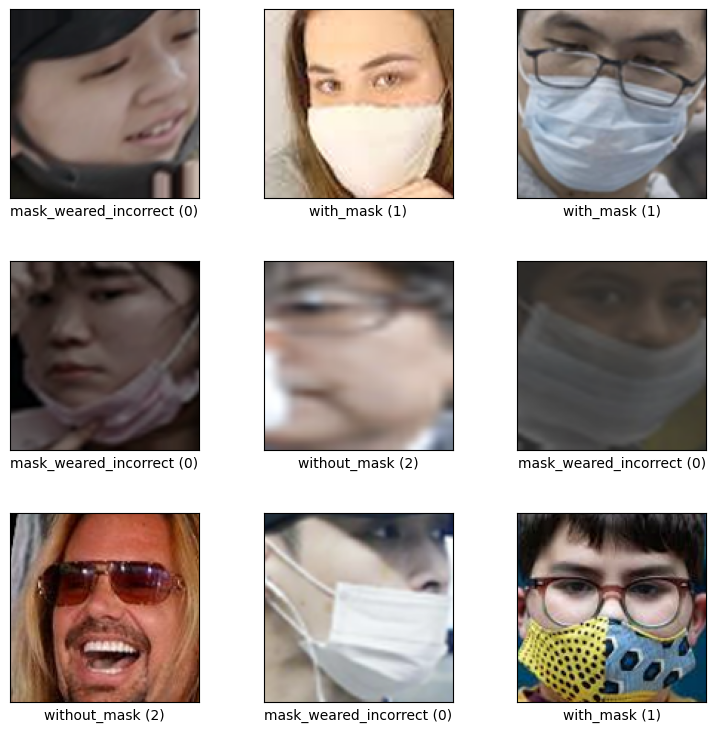

In [31]:
# #create our datasets
# train_ds = builder.as_dataset(split='train', shuffle_files=True)

# train_ds = builder.as_dataset(split='test+train[:80%]')

train_ds, test_ds = builder.as_dataset(split=['train', 'test'], shuffle_files=True, as_supervised=True)

# train_ds, test_ds = builder.as_dataset(split='test+train[:80%]', shuffle_files=True, as_supervised=True)   


# Show the images of the dataset
tfds.show_examples(train_ds, builder.info)

In [32]:
# Define parameters for the loader

import pathlib
data_dir_train = pathlib.Path(PATH+'/train')

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 8082 files belonging to 3 classes.
Using 6466 files for training.


In [33]:
image_count = len(list(data_dir_train.glob('*/*.png')))
print(image_count)

8082


## 3. Load test dataset using Tensorflow dataset builder

2024-06-04 13:20:23.642479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


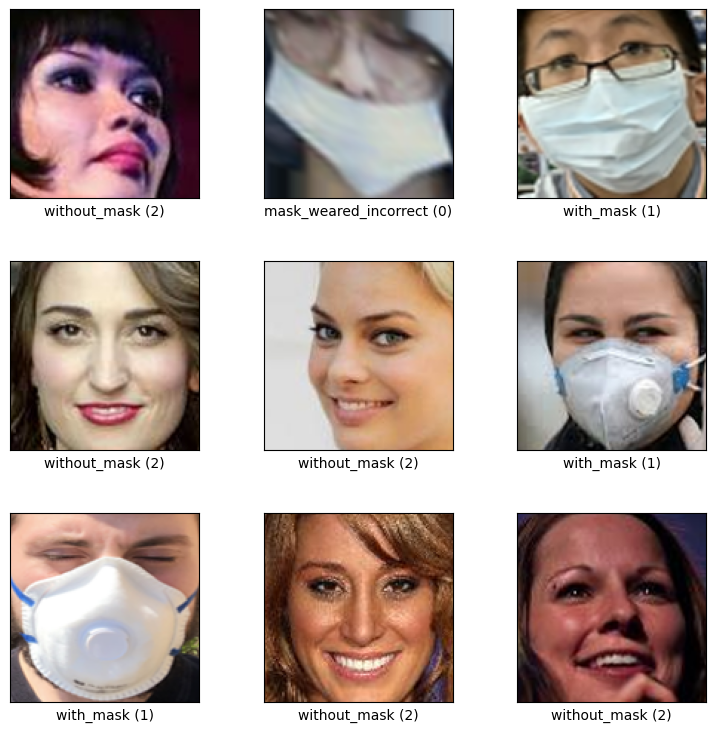

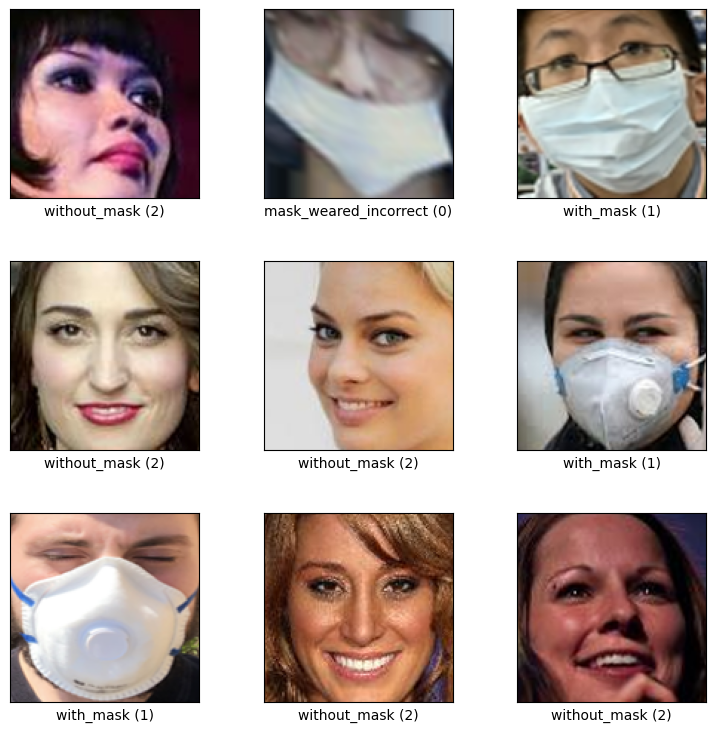

In [35]:
# #create our datasets
# test_ds = builder.as_dataset(split='test', shuffle_files=True)

# Show the images of the dataset
tfds.show_examples(test_ds, builder.info)

## 4. Build a Transfer Learning network using Keras with the following layers

### 4.1. Load EfficientNetB0 as first layers using Keras API.

### 4.2. GLobalAveragePooling2D layer

### 4.3. Dropout(0.2)

### 4.4. Dense layer with 3 neurons and activation softmax

In [6]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [36]:
# remove the last few fully connected layers of the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)


In [ ]:
# base_model.summary()

Original base model has more than 4 million parameters

In [37]:
# Fine-tune our model

# Use Sequential library from tensorflow

efficient_net_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [38]:
efficient_net_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

## 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

In [39]:
efficient_net_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 6. Train the model for 25 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [40]:
# Define a callback function
# Do a decrease learning rate over time.
# As the model is learning, if the validation accuracy is not increasing then reduce the learning reate to minimize the loss function
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=0,
    min_lr=0.00001
)

In [41]:
#Create an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, verbose=True)

In [46]:
history = efficient_net_model.fit(
    train_ds.batch(32),
    epochs=25,
    callbacks=[learning_rate_reduction, early_stopping]
)


Epoch 1/25


ValueError: Input 0 of layer "efficientnetb0" is incompatible with the layer: expected shape=(None, None, None, 3), found shape=(None, None, 128, 128, 3)

## 7. Plot training and validation accuracy and loss against epochs

# Task B

## 1. Load the Image Training and Test Datasets from the train and test folder respectively. Each image is of shape 128 x 128 x 3

## 2. Load training dataset using Keras ImageDataGenerator with validation_split=0.2

## 3. Load test dataset using Keras ImageDataGenerator

## 4. Build a Transfer Learning network using Keras with the following layers

### 4.1. Load ResNet50 as first layers using Keras API.

### 4.2. GLobalAveragePooling2D layer

### 4.3. Dropout(0.5)

### 4.4. Dense layer with 3 neurons and activation softmax

## 5. Compile the model with adam optimizer, categorical_crossentropy loss and with metrics accuracy.

## 6. Train the model for 25 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

## 7. Plot training and validation accuracy and loss against epochs

# Task C

## 1. Compare EfficientNetB0 and ResNet50 model performance and find the best model

## 2. Using the best model predict on the test dataset and plot 10 images from the test set along with its True Label and Predicted Label.